<a href="https://colab.research.google.com/github/Vkang10/Customer-Lifetime-Value-Prediction/blob/main/Customer_Lifetime_Value_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model training

In [ ]:
# import XGBoost, sklearn.linear model, sklearn.tree, sklearn.naive_bayes

from pycaret.regression import *
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, r2_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import ResidualsPlot
from sklearn import preprocessing
import pandas as pd
from sklearn.naive_bayes import GaussianNB


### Initial model

[01:59:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training RMSE:  157.94
Training R-Squared:  0.13

Testing RMSE:  176.09
Testing R-Squared:  0.1

Prediction Error Plot


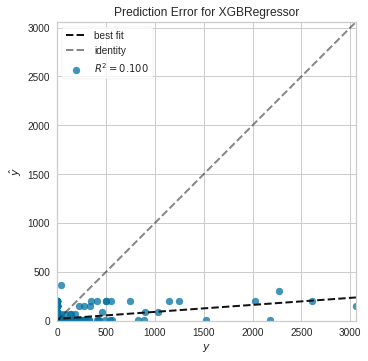

In [ ]:
# Drop rows that are with greater values when doing EDA.
dev_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 10000.00)
                    | (dev_data['visitNumber'] >= 150) 
                    | (dev_data['productQuantityPurchased'] >= 1500)].index)

dev_data = dev_data.reset_index(drop=True)

# Setup the data for SK Learn
X = dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue'], axis=1) # Feature matrix in pd.DataFrame format...fullVisitorId, session time, and future revenue aren't being used as predictor variables
y = pd.Series(dev_data.futureRevenue) # Target vector in pd.Series format

# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate XGBoost object with hyperparameters...No hyperparameter tuning is included in this example but would be beneficial
model = xgb.XGBRegressor(max_depth=1, n_estimators=20,
                           reg_alpha=10, reg_lambda=0,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=123, learning_rate=0.10)

#model = LinearRegression()
#model = DecisionTreeRegressor(max_depth=3)

# Fit the data(train the model)
model.fit(X_train, y_train)

# Calculate RMSE and R^2 for training data
train_y_pred = model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Calculate RMSE and R^2 for testing data
test_y_pred = model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(model, X_train, y_train, X_test, y_test)
viz.show() # Sometimes visualization fails after using PyCaret EDA... Have to restart runtime and skip EDA

This is a bad model. The R-squared is very low. It is also clear that most predictions are very close to 0.

There is an opportunity to improve this model through hyperparameter tuning or trying a different model algorithm. However, given the model performance is this bad, I think a more significant change is required.

Since there are so many 0 values for futureRevenue, it could be helpful to split this model into two parts. The first part will be a regression model trained on only users with non-zero futureRevenue. The second part will be a classification model trained on all users predicting the probability that they will make at least one future purchase. Our final prediction can be one of three options:
 - If our regression model is good but our classification model is bad, the prediction will be [Regression Model Prediction] * [Average Repeat Purchase Rate]
 - If our regression model is bad but our classification model is good, the prediction will be [Average futureValue] * [Classification Model Prediction]
 - If our regression model is good and our classification model is good, the prediction will be [Regression Model Prediction] * [Classification Model Prediction]

Also, we see skewed in most of the numeric variables. We'd like to normalize them for regression model.


### Regression model (repeat purchasers only)

In [ ]:
# Drop more rows than what we did in the initail model.
# Also drop any rows where futureRevenue = 0
reg_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                     | (dev_data['revenue'] >= 10000)
                    | (dev_data['visitNumber'] >= 500)
                    | (dev_data['productQuantityPurchased'] >= 1100)
                    | (dev_data['hits'] >= 380)
                    | (dev_data['pageviews'] >= 400)
                    | (dev_data['timeOnSite'] >= 15000)
                    | (dev_data['futureRevenue'] == 0)].index)


reg_data = reg_data.reset_index(drop=True)

In [ ]:
#Normalize numeric variables
reg_data_n=reg_data[['revenue', 'visitNumber','hits','pageviews','timeOnSite','firstWeekVisits','firstWeekTransactions','firstWeekRevenue','Maxproductprice','bounceRate','Frequency']]
normalized_reg_df=(reg_data_n-reg_data_n.mean())/reg_data_n.std()
normalized_reg_df.head()


,revenue,visitNumber,hits,pageviews,timeOnSite,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,Maxproductprice,bounceRate,Frequency
0,-0.555571,-0.339328,-0.047223,-0.115389,-0.714466,-0.534433,-0.303997,-0.170499,-0.140450,-0.340669,-0.294384
1,-0.044721,-0.164101,1.036170,0.972858,-0.398460,0.140882,-0.303997,-0.170499,-0.140450,3.639824,-0.294384
2,-0.540490,-0.164101,0.073154,0.015201,0.480494,-0.534433,-0.303997,-0.170499,-0.140450,-0.340669,-0.294384
3,-0.372651,3.515656,-1.040332,-1.029516,-0.561194,-0.534433,-0.303997,-0.170499,-0.908428,-0.340669,-0.294384
4,-0.209692,0.011125,-0.438448,-0.507158,-0.581062,-0.534433,-0.303997,-0.170499,0.076588,-0.340669,-0.294384


In [ ]:
#join numeric variables back with categorial variables
normal_all=normalized_reg_df.join(reg_data.drop(['revenue', 'visitNumber','hits','pageviews','timeOnSite','firstWeekVisits','firstWeekTransactions','firstWeekRevenue','Maxproductprice','bounceRate','Frequency'],axis=1))
normal_all.head()

,revenue,visitNumber,hits,pageviews,timeOnSite,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,Maxproductprice,bounceRate,...,BrandYoutubePurchased,removedItemFromCart,addedItemtoCart,HasSocialSourceReferral,futureRevenue,daytime,removedItemFromCart_week,addedItemtoCart_week,HasSocialSourceReferral_week,Promotion
0,-0.555571,-0.339328,-0.047223,-0.115389,-0.714466,-0.534433,-0.303997,-0.170499,-0.140450,-0.340669,...,0,1,1,0,91.98,0.0,0,0,0,0
1,-0.044721,-0.164101,1.036170,0.972858,-0.398460,0.140882,-0.303997,-0.170499,-0.140450,3.639824,...,0,0,1,0,181.94,NaN,0,0,0,0
2,-0.540490,-0.164101,0.073154,0.015201,0.480494,-0.534433,-0.303997,-0.170499,-0.140450,-0.340669,...,0,1,1,0,107.18,1.0,0,0,0,0
3,-0.372651,3.515656,-1.040332,-1.029516,-0.561194,-0.534433,-0.303997,-0.170499,-0.908428,-0.340669,...,0,0,0,0,155.85,1.0,0,0,0,0
4,-0.209692,0.011125,-0.438448,-0.507158,-0.581062,-0.534433,-0.303997,-0.170499,0.076588,-0.340669,...,0,0,1,0,132.58,1.0,0,0,0,0


In [ ]:
# Look at correlation between futureRevenue and other variables to select initial feature set
normal_all[normal_all.columns[:]].corr()['futureRevenue'][:] 

revenue                         0.362663
visitNumber                     0.045339
hits                            0.187032
pageviews                       0.200819
timeOnSite                      0.168338
firstWeekVisits                 0.065343
firstWeekTransactions           0.115839
firstWeekRevenue                0.194428
Maxproductprice                 0.277352
bounceRate                     -0.015191
Frequency                       0.080171
referralChannelGrouping        -0.196190
organicSearchChannelGrouping   -0.057873
directChannelGrouping           0.274020
paidSearchChannelGrouping       0.025719
chromeBrowser                  -0.037515
safariBrowser                   0.076230
macintoshOS                    -0.146410
windowsOS                       0.059102
chromeOS                        0.207824
LinuxOS                        -0.081161
california                     -0.131329
newYork                        -0.032514
bayArea                        -0.142818
Weekend         

In [ ]:
# Setup the data for SK Learn 

# Feature matrix will include variables with more than +/- 0.16 correlations to futureRevenue

X = normal_all[['directChannelGrouping','productQuantityPurchased','officePurchased','chromeOS','hits','firstWeekRevenue',"Q4","timeOnSite",
                'electronicsPurchased','Maxproductprice',"revenue",'pageviews','lifestylePurchased','referralChannelGrouping']]
y = pd.Series(normal_all.futureRevenue) # Target vector in pd.Series format



# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate XGBoost object with hyperparameters, and we tune the hyperparameters
reg_model = xgb.XGBRegressor(max_depth=1, n_estimators=155,
                          reg_alpha=700, reg_lambda=29,
                          objectvie='reg:squarederror', booster='gbtree',
                          random_state=123, learning_rate=0.45)

#reg_model = LinearRegression()
#reg_model = DecisionTreeRegressor(max_depth=3)

# Fit the data(train the model)
reg_model.fit(X_train, y_train)

# Get RMSE and R^2 for training data
train_y_pred = reg_model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Get RMSE and R^2 for testing data
test_y_pred = reg_model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(reg_model, X_train, y_train, X_test, y_test)
viz.show()

[01:05:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training RMSE:  360.71
Training R-Squared:  0.58

Testing RMSE:  481.13
Testing R-Squared:  0.36

Prediction Error Plot


We're able to make a significantly better model predicting futureValue for repeat purchasers only. R-Squared of 0.36 still isn't great but it's a lot better than our first model.

### Classification model (likelihood to purchase again)

In [ ]:
# Drop the same rows dropped in the regression model
# We will include both repeat purchasers and single purchasers here since we're trying to predict repeat purchase
cla_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 10000)
                    | (dev_data['visitNumber'] >= 500)
                    | (dev_data['productQuantityPurchased'] >= 1100)
                    | (dev_data['hits'] >= 380)
                    | (dev_data['pageviews'] >= 400)
                    | (dev_data['timeOnSite'] >= 15000)].index)

# Add column to represent a user that purchased again
# This will be our model's target
cla_data['repeatPurchaser'] = np.where(cla_data['futureRevenue'] > 0, 1, 0)

dev_data = dev_data.reset_index(drop=True)

# Look at correlation between repeatPurchaser and other variables to select initial feature set
# Correlation isn't the best metric to look at for a classification problem. 
# Feel free to use another technique to select your intial features.
cla_data[cla_data.columns[:]].corr()['repeatPurchaser'][:]


revenue                         0.121115
visitNumber                     0.082190
hits                            0.077365
pageviews                       0.073239
timeOnSite                      0.057339
referralChannelGrouping         0.028900
organicSearchChannelGrouping   -0.058219
directChannelGrouping           0.050988
paidSearchChannelGrouping      -0.030542
chromeBrowser                   0.032773
safariBrowser                  -0.031055
macintoshOS                     0.051670
windowsOS                      -0.024962
chromeOS                        0.040611
LinuxOS                        -0.041754
california                     -0.022637
newYork                         0.044682
bayArea                        -0.022081
Weekend                        -0.020192
TrafficSourceTrueDirect         0.074076
Q1                              0.003844
Q2                                   NaN
Q3                              0.007695
Q4                             -0.010442
Month           

In [ ]:
# Setup the data for SK Learn No 

# Feature matrix will include variables with +-0.7 correlations to repeatVisitor (excluding futureRevenue, which we can't use)
X = cla_data[['Frequency','visitNumber','firstWeekTransactions','TrafficSourceTrueDirect','revenue','firstWeekRevenue','productQuantityPurchased','hits','pageviews','Maxproductprice','Promotion','addedItemtoCart_week']]
y = pd.Series(cla_data.repeatPurchaser) # Target vector in pd.Series format



# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate XGBoost object with hyperparameters...No hyperparameter tuning is included in this example but would be beneficial
# cla_model = xgb.XGBClassifier(max_depth=3, n_estimators=100,
#                            reg_alpha=0.5, reg_lambda=0,
#                           objective="binary:logistic", booster='gbtree',
#                           random_state=123, learning_rate=0.1)
#cla_model = LogisticRegression()
#cla_model = DecisionTreeClassifier(max_depth=1,min_samples_leaf=7)
cla_model = GaussianNB()

# Fit the data(train the model)
cla_model.fit(X_train, y_train)

# Calculate evaluation metrics for classification model
train_y_pred = cla_model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

test_y_pred = cla_model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data


print('\n clasification report:\n', classification_report(test_y_true, test_y_pred))
print('\n confussion matrix:\n',confusion_matrix(test_y_true, test_y_pred))
print('\n ROC AUC: \n',roc_auc_score(test_y_true, test_y_pred))


 clasification report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1125
           1       0.24      0.25      0.24       102

    accuracy                           0.87      1227
   macro avg       0.58      0.59      0.59      1227
weighted avg       0.87      0.87      0.87      1227


 confussion matrix:
 [[1045   80]
 [  77   25]]

 ROC AUC: 
 0.5869934640522876


ROC AUC is up to 0.6, which we later would like to see whether it could predict well for holdout dataset.

## Holdout predictions

As a final step, we compare different options for making a prediction to a "naive estimate." The four options we consider for making a prediction are:
- Naive estimate, which assumes each customer's 8-90 day future revenue will be equal to the average future revenue observed in the development dataset.
- Initial model's predictions. This was the first model with the low R-squared.
- Regression only model, which will take the predictions from the regression model trained on repeat purchasers multiplied by the average repeat purchase rate observered in the development dataset.
*  Classification only model, which uses the prediction from the classification model multiplied by the average future revenue from repeat purchasers.
*  Predicted model, which takes the prediction from regression model times with the prediction from the classification model.

Evaluate the model based on three metrics:
- Mean absolute error, the primary KPI
- Mean squared error, which is more sensitive to extreme errors
- Average error, which will indicate overall prediction bias

In [ ]:
# Calculate average repeat purchase rate from development dataset
dev_data['repeatPurchaser'] = np.where(dev_data['futureRevenue'] > 0, 1, 0)
AvgRepeat = np.mean(dev_data['repeatPurchaser'])

# Calculate average future revenue observed in the development dataset
AvgCLV = np.mean(dev_data['futureRevenue']) 
Repeatdataset=dev_data[dev_data.repeatPurchaser == 1]
AvgCLV_2=np.mean(Repeatdataset['futureRevenue'])
# Create naive estimate for all customers, which is equal to average future revenue from development dataset
holdout_data['NaiveEstimate'] = AvgCLV 

holdout_data['repeatPurchaser']=np.where(holdout_data['futureRevenue'] > 0, 1, 0)

# Set up holdout data for initial model
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue','NaiveEstimate','repeatPurchaser'], axis=1) 
y_holdout = pd.Series(holdout_data.futureRevenue)

y_cla_holdout=pd.Series(holdout_data.repeatPurchaser)

holdout_y_pred = model.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data
holdout_y_cla_true=y_cla_holdout # True values for claffication holdout data

# Set up data for regression only model
reg_X_holdout = holdout_data[['directChannelGrouping','productQuantityPurchased','officePurchased','chromeOS','hits',"firstWeekRevenue","Q4","timeOnSite",
                'electronicsPurchased','Maxproductprice',"revenue",'pageviews','lifestylePurchased','referralChannelGrouping']]

reg_holdout_y_pred = reg_model.predict(reg_X_holdout) * AvgRepeat # Regression only predictions for holdout data
# Set up data for classfication only model

cla_X_holdout = holdout_data[['Frequency','visitNumber','firstWeekTransactions','TrafficSourceTrueDirect','revenue','firstWeekRevenue','productQuantityPurchased','hits','pageviews','Maxproductprice','Promotion','addedItemtoCart_week']]
cla_holdout_y_pred = cla_model.predict(cla_X_holdout) * AvgCLV_2 # classfication only predictions for holdout data
# Set up data for predicted model

cla_X_holdout_y_pred_pure = cla_model.predict(cla_X_holdout)
reg_holdout_y_pred_pure = reg_model.predict(reg_X_holdout) 

Predict_model=cla_X_holdout_y_pred_pure*reg_holdout_y_pred_pure
# Get RMSE and MAE error based on naive estimate
Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
Naive_RMSE = np.sqrt(Naive_MSE)
Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression only model
Reg_Model_MAE = np.mean(np.absolute(holdout_y_true - reg_holdout_y_pred))
Reg_Model_MSE = mse(holdout_y_true, reg_holdout_y_pred)
Reg_Model_RMSE = np.sqrt(Reg_Model_MSE)
Reg_Model_Avg_Error = np.mean(reg_holdout_y_pred - holdout_y_true)

# Get RMSE and MAE error based on regression only model
Predict_model_MAE = np.mean(np.absolute(holdout_y_true - reg_holdout_y_pred_pure*cla_X_holdout_y_pred_pure))
Predict_model_MSE = mse(holdout_y_true, reg_holdout_y_pred_pure*cla_X_holdout_y_pred_pure)
Predict_model_RMSE = np.sqrt(Predict_model_MSE)
Predict_model_Avg_Error = np.mean(reg_holdout_y_pred_pure*cla_X_holdout_y_pred_pure - holdout_y_true)
# Get RMSE and MAE error based on classfication only model
cla_Model_MAE = np.mean(np.absolute(holdout_y_true - cla_holdout_y_pred))
cla_Model_MSE = mse(holdout_y_true, cla_holdout_y_pred)
cla_Model_RMSE = np.sqrt(cla_Model_MSE)
cla_Model_Avg_Error = np.mean(cla_holdout_y_pred - holdout_y_true)

print("\nNaive MAE: ", np.round(Naive_MAE, 2))
print("Naive RMSE: ", np.round(Naive_RMSE, 2))
print("Naive Avg Error: ", np.round(Naive_Avg_Error, 2))

print("\nInitial Model MAE: ", np.round(Initial_Model_MAE, 2))
print("Initial Model RMSE: ", np.round(Initial_Model_RMSE, 2))
print("Initial Model Avg Error: ", np.round(Initial_Model_Avg_Error, 2))

print("\nRegression Only Model MAE: ", np.round(Reg_Model_MAE, 2))
print("Regression Only Model RMSE: ", np.round(Reg_Model_RMSE, 2))
print("Regression Only Model Avg Error: ", np.round(Reg_Model_Avg_Error, 2))

print("\nClassfication Only Model MAE: ", np.round(cla_Model_MAE, 2))
print("Classfication Only Model RMSE: ", np.round(cla_Model_RMSE, 2))
print("Classfication Only Model Avg Error: ", np.round(cla_Model_Avg_Error, 2))

print("\nPredict_model_MAE MAE: ", np.round(Predict_model_MAE, 2))
print("Predict_model_MAE RMSE: ", np.round(Predict_model_RMSE, 2))
print("Predict_model_MAE Avg Error: ", np.round(Predict_model_Avg_Error, 2))


Naive MAE:  31.59
Naive RMSE:  70.2
Naive Avg Error:  10.83

Initial Model MAE:  26.55
Initial Model RMSE:  72.86
Initial Model Avg Error:  -5.54

Regression Only Model MAE:  18.76
Regression Only Model RMSE:  69.25
Regression Only Model Avg Error:  -3.7

Classfication Only Model MAE:  30.98
Classfication Only Model RMSE:  102.72
Classfication Only Model Avg Error:  10.21

Predict_model_MAE MAE:  37.37
Predict_model_MAE RMSE:  141.6
Predict_model_MAE Avg Error:  16.5


The regression only model trained on repeat purchasers performed the best out of the options available. It lowered the MAE significantly compared to the naive estimate. It also had a lower prediction bias (measured by average prediction error) compared to the naive estimate. The naive estimate would tend to over-predict for the holdout dataset more than the regression only model.

We're able to reduce the MAE ~40.6%. The regressional model includes variable like directChannelGrouping, productQuantityPurchased, officePurchased, chromeOS, hits, firstWeekRevenue, Q4, timeOnSite, electronicsPurchased Maxproductprice, revenue, pageviews, lifestylePurchased referralChannelGrouping. Based on these variables, Google Merchandise Store is able to calculate the newly aquired customers' lifetime values. We also provides several recommendations:


*   Focus on providing special offers to specific product categories - office goods, lifestyle items, and electronic products
*  Targeting the “Chrome” user base 
* Efficient allocation of ads budget by focusing  more on direct visitors
* Provide pop-up promotions/coupon when users have interacted with the website to a certain threshold level
* Increased allocation of Advertising budget on the 4th Quarter
* Targeting high spenders and buyers of expensive products 

An automated Smart bidding strategy is most advisable for eCommerce sites like Google Merchandise store, where clients can set up contextual signals like device operating system, time of the day/week etc.  Such smart bidding takes into account if a user has browsed a product during a previous site visit, is on a loyalty program list the client has uploaded, or has a profile similar to existing customers. 








